In [1]:
import torch
from torch import nn
from d2l import torch as d2l

d:\programfiles\Anaconda\anaconda\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] 找不到指定的程序。
  warn(f"Failed to load image Python extension: {e}")


In [2]:
n_train = 50
x_train, _ = torch.sort(torch.rand(n_train) * 5)

def f(x):
    return 2 * torch.sin(x) + x ** 0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))
x_test = torch.arange(0, 5, 0.1)
print(x_test)
y_truth = f(x_test)
n_test = len(x_test)
n_test

tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000, 1.0000, 1.1000, 1.2000, 1.3000, 1.4000, 1.5000, 1.6000, 1.7000,
        1.8000, 1.9000, 2.0000, 2.1000, 2.2000, 2.3000, 2.4000, 2.5000, 2.6000,
        2.7000, 2.8000, 2.9000, 3.0000, 3.1000, 3.2000, 3.3000, 3.4000, 3.5000,
        3.6000, 3.7000, 3.8000, 3.9000, 4.0000, 4.1000, 4.2000, 4.3000, 4.4000,
        4.5000, 4.6000, 4.7000, 4.8000, 4.9000])


50

In [3]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5);

tensor([0.0000, 0.3582, 0.6733, 0.9727, 1.2593, 1.5332, 1.7938, 2.0402, 2.2712,
        2.4858, 2.6829, 2.8616, 3.0211, 3.1607, 3.2798, 3.3782, 3.4556, 3.5122,
        3.5481, 3.5637, 3.5597, 3.5368, 3.4960, 3.4385, 3.3654, 3.2783, 3.1787,
        3.0683, 2.9489, 2.8223, 2.6905, 2.5554, 2.4191, 2.2835, 2.1508, 2.0227,
        1.9013, 1.7885, 1.6858, 1.5951, 1.5178, 1.4554, 1.4089, 1.3797, 1.3684,
        1.3759, 1.4027, 1.4490, 1.5151, 1.6009])
tensor([2.4002, 2.4002, 2.4002, 2.4002, 2.4002, 2.4002, 2.4002, 2.4002, 2.4002,
        2.4002, 2.4002, 2.4002, 2.4002, 2.4002, 2.4002, 2.4002, 2.4002, 2.4002,
        2.4002, 2.4002, 2.4002, 2.4002, 2.4002, 2.4002, 2.4002, 2.4002, 2.4002,
        2.4002, 2.4002, 2.4002, 2.4002, 2.4002, 2.4002, 2.4002, 2.4002, 2.4002,
        2.4002, 2.4002, 2.4002, 2.4002, 2.4002, 2.4002, 2.4002, 2.4002, 2.4002,
        2.4002, 2.4002, 2.4002, 2.4002, 2.4002])


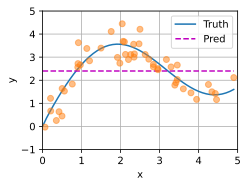

In [4]:
# 10.2.2 平均汇聚
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
print(y_truth)
print(y_hat)

plot_kernel_reg(y_hat)

x_test:tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000, 1.0000, 1.1000, 1.2000, 1.3000, 1.4000, 1.5000, 1.6000, 1.7000,
        1.8000, 1.9000, 2.0000, 2.1000, 2.2000, 2.3000, 2.4000, 2.5000, 2.6000,
        2.7000, 2.8000, 2.9000, 3.0000, 3.1000, 3.2000, 3.3000, 3.4000, 3.5000,
        3.6000, 3.7000, 3.8000, 3.9000, 4.0000, 4.1000, 4.2000, 4.3000, 4.4000,
        4.5000, 4.6000, 4.7000, 4.8000, 4.9000])
X_repeat:tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
        [0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000],
        ...,
        [4.7000, 4.7000, 4.7000,  ..., 4.7000, 4.7000, 4.7000],
        [4.8000, 4.8000, 4.8000,  ..., 4.8000, 4.8000, 4.8000],
        [4.9000, 4.9000, 4.9000,  ..., 4.9000, 4.9000, 4.9000]])


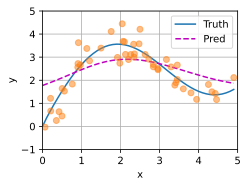

In [5]:
# 10.2.3 非参数注意力汇聚
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
print(f"x_test:{x_test}")
print(f"X_repeat:{X_repeat}")
attention_weights = nn.functional.softmax(-(X_repeat - x_train) ** 2 / 2, dim = 1)
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

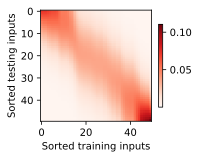

In [6]:
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

In [7]:
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
torch.bmm(X, Y).shape

torch.Size([2, 1, 6])

In [8]:
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))

tensor([[[ 4.5000]],

        [[14.5000]]])

In [9]:
class NWKernelRegression(nn.Module):  # 意味着它可以包含神经网络层并且能够自动进行反向传播计算梯度。
    def __init__(self, **kwargs) -> None:  # 接受任意数量的关键字参数
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))  # 一维张量
        
    def forward(self, queries, keys, values):  # 查询 键 值
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(
            -((queries - keys) * self.w) ** 2 / 2, dim=1
        )
        return torch.bmm(self.attention_weights.unsqueeze(1), 
                         values.unsqueeze(-1)).reshape(-1)

In [10]:
# train
X_tile = x_train.repeat((n_train, 1))
Y_tile = y_train.repeat((n_train, 1))

keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

In [11]:
print(X_tile)
print(Y_tile)

tensor([[0.0635, 0.2042, 0.2093,  ..., 4.4280, 4.4593, 4.9012],
        [0.0635, 0.2042, 0.2093,  ..., 4.4280, 4.4593, 4.9012],
        [0.0635, 0.2042, 0.2093,  ..., 4.4280, 4.4593, 4.9012],
        ...,
        [0.0635, 0.2042, 0.2093,  ..., 4.4280, 4.4593, 4.9012],
        [0.0635, 0.2042, 0.2093,  ..., 4.4280, 4.4593, 4.9012],
        [0.0635, 0.2042, 0.2093,  ..., 4.4280, 4.4593, 4.9012]])
tensor([[-0.0339,  1.2151,  0.6681,  ...,  1.4240,  1.1614,  2.1158],
        [-0.0339,  1.2151,  0.6681,  ...,  1.4240,  1.1614,  2.1158],
        [-0.0339,  1.2151,  0.6681,  ...,  1.4240,  1.1614,  2.1158],
        ...,
        [-0.0339,  1.2151,  0.6681,  ...,  1.4240,  1.1614,  2.1158],
        [-0.0339,  1.2151,  0.6681,  ...,  1.4240,  1.1614,  2.1158],
        [-0.0339,  1.2151,  0.6681,  ...,  1.4240,  1.1614,  2.1158]])


In [12]:
print(keys)
print(values)

tensor([[0.2042, 0.2093, 0.3525,  ..., 4.4280, 4.4593, 4.9012],
        [0.0635, 0.2093, 0.3525,  ..., 4.4280, 4.4593, 4.9012],
        [0.0635, 0.2042, 0.3525,  ..., 4.4280, 4.4593, 4.9012],
        ...,
        [0.0635, 0.2042, 0.2093,  ..., 4.3414, 4.4593, 4.9012],
        [0.0635, 0.2042, 0.2093,  ..., 4.3414, 4.4280, 4.9012],
        [0.0635, 0.2042, 0.2093,  ..., 4.3414, 4.4280, 4.4593]])
tensor([[ 1.2151,  0.6681,  0.2549,  ...,  1.4240,  1.1614,  2.1158],
        [-0.0339,  0.6681,  0.2549,  ...,  1.4240,  1.1614,  2.1158],
        [-0.0339,  1.2151,  0.2549,  ...,  1.4240,  1.1614,  2.1158],
        ...,
        [-0.0339,  1.2151,  0.6681,  ...,  1.4998,  1.1614,  2.1158],
        [-0.0339,  1.2151,  0.6681,  ...,  1.4998,  1.4240,  2.1158],
        [-0.0339,  1.2151,  0.6681,  ...,  1.4998,  1.4240,  1.1614]])


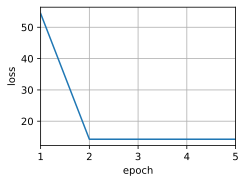

In [13]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')  # 均方误差损失函数
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

# 均方误差 MSELoss与 reduction='none'
均方误差测量了模型的预测值与真实标签之间的平方差的均值。这有助于衡量模型的预测误差的大小。
## 均方误差
均方误差（Mean Squared Error，MSE）是一种常用于回归问题的损失函数，用于度量模型的预测值与真实标签之间的差异的平方的均值。MSE通常用于评估模型在连续数值预测任务中的性能，例如房价预测、股票价格预测等。

MSE 的数学定义如下：

对于单个样本 $(x, y)$，其中 $x$ 是模型的输入特征，$y$ 是真实的目标值，$y'$ 是模型的预测值，MSE 定义为：
$$
MSE(x, y) = \frac{1}{n} \sum_{i=1}^{n} (y'_i - y_i)^2
$$
其中：
$n$ 是样本的数量。
$y'_i$ 是模型对第 $i$ 个样本的预测值。
$y_i$ 是第 $i$ 个样本的真实目标值。

## reduction='none'
reduction='none'：这里指定了损失函数的参数 reduction 为 'none'。reduction 参数用于控制损失的降维方式。在这里，设置为 'none' 表示不进行降维操作。也就是说，对于每个样本，损失函数将计算该样本的均方误差，而不对这些损失进行平均或求和。这种设置在训练循环中可能很有用，因为它允许你查看每个样本的损失，而不是对它们进行聚合。
**个人以为，不加这个，就类似于后续进行了l.sum()等操作。**



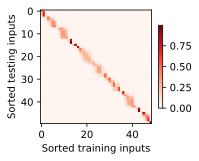

In [14]:
# 绘制注意力热力图
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0), 
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

# unsqueeze 的用法
unsqueeze 是PyTorch中用于增加张量维度的方法之一。它在张量的指定位置插入一个新的维度，将原有的维度数增加1。这个新维度的大小通常是1，但你也可以指定其他大小。